## Семинар 14. VAE в Pyro

In [1]:
%!pip install pyro-ppl

UsageError: Line magic function `%!pip` not found.


In [2]:
import os

import numpy as np
import torch
from pyro.contrib.examples.util import MNIST
import torch.nn as nn
import torchvision.transforms as transforms

import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util  # patches torchvision
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [3]:
assert pyro.__version__.startswith("1.8.6")
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)
# Enable smoke test - run the notebook cells on CI.
smoke_test = "CI" in os.environ

In [4]:
# for loading and batching MNIST dataset
def setup_data_loaders(batch_size=128, use_cuda=False):
    root = "./data"
    download = True
    trans = transforms.ToTensor()
    train_set = MNIST(root=root, train=True, transform=trans, download=download)
    test_set = MNIST(root=root, train=False, transform=trans)

    kwargs = {"num_workers": 10, "pin_memory": use_cuda}
    train_loader = torch.utils.data.DataLoader(
        dataset=train_set, batch_size=batch_size, shuffle=True, **kwargs
    )
    test_loader = torch.utils.data.DataLoader(
        dataset=test_set, batch_size=batch_size, shuffle=False, **kwargs
    )
    return train_loader, test_loader

In [5]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, (hidden_dim // 2) * 3)
        self.fc31 = nn.Linear((hidden_dim // 2) * 3, 784)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc2(self.softplus(self.fc1(z))))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x 784
        loc_img = self.sigmoid(self.fc31(hidden))
        return loc_img

In [6]:
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(784, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc31 = nn.Linear(hidden_dim // 2, z_dim)
        self.fc32 = nn.Linear(hidden_dim // 2, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # define the forward computation on the image x
        # first shape the mini-batch to have pixels in the rightmost dimension
        x = x.reshape(-1, 784)
        # then compute the hidden units
        hidden = self.softplus(self.fc2(self.softplus(self.fc1(x))))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc31(hidden)
        z_scale = torch.exp(self.fc32(hidden))
        return z_loc, z_scale

In [7]:
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=50, hidden_dim=400, use_cuda=False):
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim))) * 20
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z
            loc_img = self.decoder(z)
            # score against actual images
            pyro.sample(
                "obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 784)
            )

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img

In [9]:
def train(svi, train_loader, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.0
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, _ in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

In [10]:
def evaluate(svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.0
    # compute the loss over the entire test set
    for x, _ in test_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test

In [11]:
# Run options
LEARNING_RATE = 1.0e-3
USE_CUDA = True

# Run only for a single iteration for testing
NUM_EPOCHS = 100
TEST_FREQUENCY = 5
z_dim = 2

In [12]:
train_loader, test_loader = setup_data_loaders(batch_size=256, use_cuda=USE_CUDA)

# clear param store
pyro.clear_param_store()

# setup the VAE
vae = VAE(use_cuda=USE_CUDA, z_dim=z_dim, hidden_dim=500)

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

## Сохранение модели

In [13]:
# torch.save(vae.state_dict(), f"vae_z_dim-{vae.z_dim}_hid-{500}.pt")

## Визуализация модели

In [14]:
vae_loaded = VAE(z_dim=z_dim, hidden_dim=500)
vae_loaded.load_state_dict(torch.load(f"vae_z_dim-{z_dim}_hid-{500}.pt"))

<All keys matched successfully>

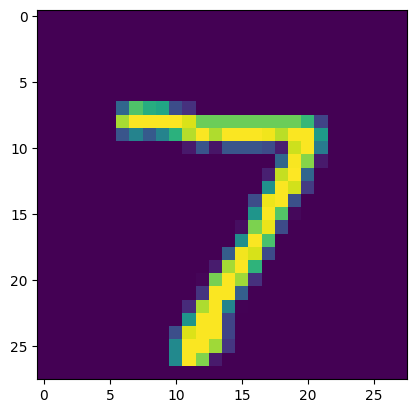

In [15]:
import matplotlib.pyplot as plt

train_loader, test_loader = setup_data_loaders(batch_size=256, use_cuda=USE_CUDA)

x = test_loader.dataset[0][0]
plt.imshow(x[0, :, :])

In [16]:
vae_loaded.to("cpu")
vae_loaded.eval()
x_rec = vae_loaded.reconstruct_img(x)

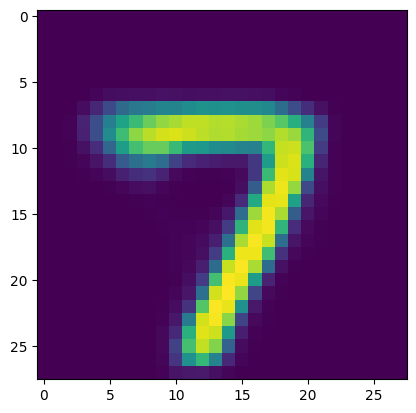

In [17]:
plt.imshow(x_rec.reshape(28, 28).detach().numpy())

In [24]:
from tqdm import tqdm

ys = []
zs = []
for x, y in tqdm(test_loader):
    ys.append(y)
    z_batch = vae_loaded.encoder(x)
    zs.append(z_batch[0])

y = torch.cat(ys).numpy()
z = torch.cat(zs, dim=0).detach().numpy()

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:00<00:00, 42.29it/s]


In [25]:
import seaborn as sns
import pandas as pd

latent_data = pd.DataFrame({"z1": z[:, 0], "z2": z[:, 1], "y": y})

<AxesSubplot:xlabel='z1', ylabel='z2'>

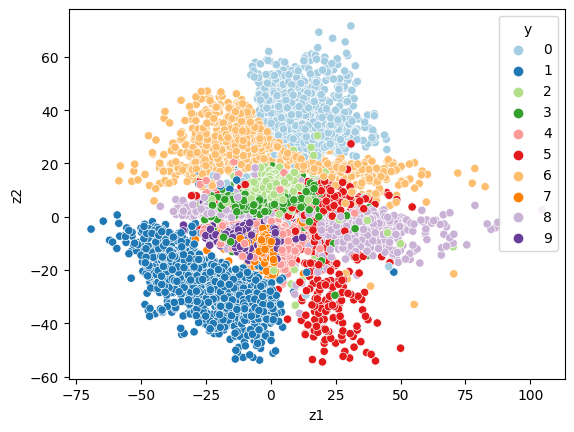

In [26]:
sns.scatterplot(data=latent_data, x="z1", y="z2", hue="y", palette="Paired")